In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import unicodedata
import random
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU')

Training on GPU!


In [ ]:
lines = open("/content/textbook", "r").read().split('\n')
len(lines)

82918

In [ ]:
lines = ['<sos> ' + line +' <eos>' for line in lines[:10000]]

In [ ]:
test_sentence = [s.split() for s in lines]
print(test_sentence[0])

['<sos>', 'hello', ',', 'what', "'s", 'your', 'name', '?', 'my', 'name', 'is', 'sara', '.', 'where', 'are', 'you', 'from', '?', 'i', "'m", 'from', 'canada', '.', 'this', 'is', 'our', 'flag', '.', 'oh', ',', 'i', 'like', 'it', '!', '<eos>']


In [ ]:
vocab = []
for sent in test_sentence:
    for word in sent: vocab.append(word)
        
vocab = set(vocab)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

print(voc_len)

2853


In [ ]:
# MAX_LEN = 75
context_num=3

In [ ]:
input_ids = []
for sent in test_sentence:
    input_ids.append([word_to_ix[w] for w in sent])

# input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# print(input_ids[0])

In [ ]:
inp = []
tar = []

for sentence in input_ids:
    for i in range(len(sentence)-context_num):
        context = sentence[i:i+context_num]
        target = sentence[i+context_num]
        inp.append(context)
        tar.append(torch.tensor([target]))

In [ ]:
inp = torch.tensor(inp)
data_len = len(inp)
print(data_len)

377892


In [ ]:
# for i, t in zip(inp, tar):
#     print(i.size())
#     print(i)
#     print(t)
#     break

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size*context_num, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0

    output, hidden = decoder(inp.cuda(), hidden) 
    loss += criterion(output, target.cuda())

    loss.backward()
    decoder_optimizer.step()
    
    return loss.data.item() 

In [ ]:
n_epochs = 10
print_every = 2
plot_every = 2
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

start = time.time()
all_losses = []
decoder.cuda()
decoder.train()

for epoch in range(1, n_epochs + 1):
    print("Epoch: ", epoch)
    loss_avg = 0
    for i,t in zip(inp, tar):
        loss = train(i,t)       
        loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%)]' % (time_since(start), epoch, epoch / n_epochs * 100))
        print(generate())

    if epoch % plot_every == 0:
        all_losses.append((loss_avg/data_len) / plot_every)

In [ ]:
def generate(prime_str='the name of the dog', predict_len=75, temperature=0.8, model=decoder):
    torch.no_grad()
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        
        inp = prime_input[-1*context_num:] 
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = F.softmax(output).data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

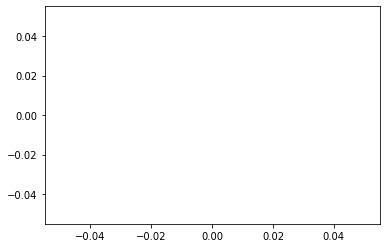

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [ ]:
torch.save(decoder, 'rnnmodel.pt')

In [ ]:
print(generate('<sos> what is you name', 75, temperature=0.2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<sos> what is you name fireflies tis shoe filled prices taking ... care numbers sars limitations palm disappearing sounds rock poster better sticks buildings curry ... arabia desert much instead finishes giok dolphins j-o-n-e-s cleaned bthanks behavior receive were these evenings there abha carrot rolls early cup send project chatting weighs mr. desert slow eyes watson it done talked late pig cage six third pool brian dancers tree hopeful started meanings ( mongolia actor does about ran sea me seaweed


In [ ]:
model = torch.load('./rnnmodel.pt')
model.eval()

RNN(
  (encoder): Embedding(2853, 100)
  (rnn): GRU(300, 100, batch_first=True)
  (decoder): Linear(in_features=100, out_features=2853, bias=True)
)

In [ ]:
print(generate('<sos> what is you name', 75, temperature=0.2, model=model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<sos> what is you name feet tuesday gets grandma please father ranger arrived moves two father scarves ghana clair cage drawing heard back picked piggy julie locker seconds spicy iran bibimbap if greek chest get asian bori lincoln bmay african work write heart yunho sujin scare prepare webs fans best 'clock duck gildong mr.smith space word ) sat did an foreigners children toothache special flying men wash i. sandwich master rains blocks board spanish yourself plates eats clerkand cursing again


In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
